## Introduction

The current input we have that can be used for querying for CZO publications is a csv file with 125 award numbers, CZO site names, and variations of 'Critical Zone Observatory'. The results returned from the award numbers, some site names, and some variants of 'Critical Zone Observatory' are fairly precise. Some site names are quite generic, however, and they return too many results. Dimensions only returns the first 1000 results. We need to see if we can reduce the noise in the search layer so that the 1000 returned are
more likely to be relevant. 

## Dependencies

In [3]:
import dimcli, itertools, json, requests, sys
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import pandas as pd
from datetime import datetime
from dimcli.utils import *
from requests.auth import AuthBase
# Need to add to the path to import local files
sys.path.insert(1, '../../../')
import helper
sys.path.insert(1, '../../../../')
import config 

## Query Terms

In [2]:
input = pd.read_csv('../data/award_numbers_input.csv', header=0)

# Get the award numbers from the df
awards = input['AwardNumber']

# Site names to search
search_terms = ['Boulder Creek', 'Calhoun', 'Santa Catalina Mountains', 'Jemez River Basin', 'Christina River Basin', 'Eel River', 'Intensively Managed Landscapes', 'Luquillo', 'Reynolds Creek', 'Susquehanna Shale Hills', 'Southern Sierra', 'CZO', 'Critical Zone Observatory']


## Intervention

The thing we hope to learn is whether filtering search terms by research category will improve the quality of the returned results. 

In [3]:
# Get Dimesnions publications
# connect to the database
dimcli.login(config.username, config.password, config.endpoint)
dsl = dimcli.Dsl()

csv_fields = ["title", "authors", "dimensions_id", "doi", "doi_url", "publisher", "journal", "volume", "issue", "pages", "pub_year", "concepts", "concepts_scores", "category_bra", "category_for", "provenance", "query_term", "pub_harvested_date"]
dimensions = pd.DataFrame(columns=csv_fields)

Dimcli - Dimensions API Client (v0.9.1)
Connected to: https://app.dimensions.ai - DSL v1.31
Method: manual login


### Query all terms without categories

In [5]:
results_wo_category = pd.read_csv('../data/search_results_without_categories.csv', header=0)
f"There are {results_wo_category.shape[0]} publicaitons."

'There are 41435 publicaitons.'

There is room to improve the recall slightly by adding more publications. For some query terms there are more than 5,000 results (the maximum we have returned for any given term). However, Dimensions has a cap of 50,000 results. In order to expand beyond that we need to construct separate queries and merge the results. Since this adds to the complexity of the algorithm, it is not desirable. 

In [6]:
# Some publicaitons may have multiple search terms which means they will appear multiple times.
# Lets remove the duplicates.
results_wo_category.drop_duplicates(subset='doi', keep='first', inplace=True)
f"After duplicates are removed, there are {results_wo_category.shape[0]} publicaitons remaining."

'After duplicates are removed, there are 36330 publicaitons remaining.'

In [7]:
# Load the reported publicaitons
reported_pubs = pd.read_csv('../data/reported_publications.csv')

Total: 36600


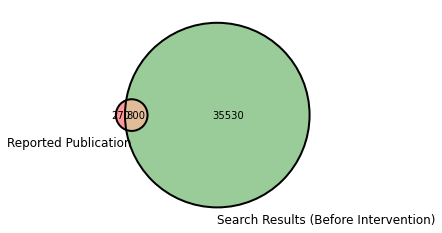

Precision: 0.02
Recall: 0.75


In [8]:
helper.plot_venn(reported_pubs['doi'], results_wo_category['doi'], 'Reported Publication', 'Search Results (Before Intervention)')

### Query all terms and filter out results from outside categories

In [16]:
results_w_category = pd.read_csv('../data/search_results_with_categories.csv', header=0)
results_w_category.columns = ["title", "authors", "dimensions_id", "doi", "doi_url", "publisher", "journal", "volume", "issue", "pages", "pub_year", "concepts", "concepts_scores", "category_bra", "category_for", "provenance", "query_term", "pub_harvested_date"]
f"There are {results_w_category.shape[0]} publicaitons."

'There are 72853 publicaitons.'

In [17]:
results_w_category.head()

,title,authors,dimensions_id,doi,doi_url,publisher,journal,volume,issue,pages,pub_year,concepts,concepts_scores,category_bra,category_for,provenance,query_term,pub_harvested_date
0,Soil structure and soil moisture dynamics infe...,"[{'raw_affiliation': ['Olson Engineering, Unit...",pub.1139611447,10.1016/j.catena.2021.105553,https://doi.org/10.1016/j.catena.2021.105553,Elsevier,"{'id': 'jour.1137268', 'title': 'Catena'}",207,NaN,105553,2021.0,"['preferential flow paths', 'pedogenic calcium...","[{'concept': 'preferential flow paths', 'relev...",NaN,"['0503 Soil Sciences', '04 Earth Sciences', '0...",dimensions,CZO,13/09/2021 14:42:08
1,A room-temperature aniline sensor based on Ce ...,[{'raw_affiliation': ['College of Materials an...,pub.1139215192,10.1016/j.jallcom.2021.160988,https://doi.org/10.1016/j.jallcom.2021.160988,Elsevier,"{'id': 'jour.1041821', 'title': 'Journal of Al...",885,NaN,160988,2021.0,"['semiconductor metal oxides', 'abundant oxyge...","[{'concept': 'semiconductor metal oxides', 're...",NaN,"['0912 Materials Engineering', '09 Engineering']",dimensions,CZO,13/09/2021 14:42:08
2,Preservation of granulite in a partially eclog...,[{'raw_affiliation': ['Institut für Mineralogi...,pub.1140279759,10.1016/j.lithos.2021.106413,https://doi.org/10.1016/j.lithos.2021.106413,Elsevier,"{'id': 'jour.1052490', 'title': 'Lithos'}",400,NaN,106413,2021.0,"['Bergen Arcs', 'transition zone', 'hand-speci...","[{'concept': 'Bergen Arcs', 'relevance': 0.535...",NaN,"['04 Earth Sciences', '0403 Geology']",dimensions,CZO,13/09/2021 14:42:08
3,Effect of characteristic component on diesel s...,[{'raw_affiliation': ['State Key Laboratory of...,pub.1139981530,10.1016/j.fuel.2021.121306,https://doi.org/10.1016/j.fuel.2021.121306,Elsevier,"{'id': 'jour.1044923', 'title': 'Fuel'}",303,NaN,121306,2021.0,"['diesel steam reforming', 'Ni-Rh', 'steam ref...","[{'concept': 'diesel steam reforming', 'releva...",NaN,"['03 Chemical Sciences', '0306 Physical Chemis...",dimensions,CZO,13/09/2021 14:42:08
4,U- and Th- series disequilibria in separated s...,[{'raw_affiliation': ['Institut Terre Environn...,pub.1139966236,10.1016/j.chemgeo.2021.120455,https://doi.org/10.1016/j.chemgeo.2021.120455,Elsevier,"{'id': 'jour.1026405', 'title': 'Chemical Geol...",583,NaN,120455,2021.0,"['Fe-oxides', 'bulk soil scale', 'shallow soil...","[{'concept': 'Fe-oxides', 'relevance': 0.458},...",NaN,['0406 Physical Geography and Environmental Ge...,dimensions,CZO,13/09/2021 14:42:08


In [18]:
# Some publicaitons may have multiple search terms which means they will appear multiple times.
# Lets remove the duplicates.
results_w_category.drop_duplicates(subset='doi', keep='first', inplace=True)
f"After duplicates are removed, there are {results_w_category.shape[0]} publicaitons remaining."

'After duplicates are removed, there are 68091 publicaitons remaining.'

Total: 68352


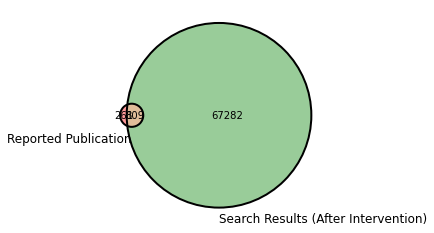

Precision: 0.01
Recall: 0.76


In [19]:
helper.plot_venn(reported_pubs['doi'], results_w_category['doi'], 'Reported Publication', 'Search Results (After Intervention)')

Given that we want to report all research, we should aim maximize recall and try to clean up precision later. However,  a one percent increase in recall does not warrant a significant increase in labor. A final decision about which set to use can be made after trying to filter out the false positive results.